# 1. Describe the data
- It has 76 rows
- There are 3 variables:
    - csa: Indicator of childhood sexual abuse (1 = yes, 0 = no).
    - cpa: Score on a standardized scale for childhood physical abuse.
    - ptsd: Score on a standardized scale for post-traumatic stress disorder.
- The data come from Rodriguez et al. (1997), studying the effects of childhood sexual abuse (CSA) on adult females. Forty-five women with CSA were measured for post-traumatic stress disorder (PTSD) and childhood physical abuse (CPA) on standardized scales. Thirty-one women without CSA were also measured.

# 2. Load packages and data

In [1]:
%%capture
pip install faraway

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import faraway.utils

In [3]:
import faraway.datasets.sexab
sexab = faraway.datasets.sexab.load()
sexab.head()

,cpa,ptsd,csa
1,2.04786,9.71365,Abused
2,0.83895,6.16933,Abused
3,-0.24139,15.15926,Abused
4,-1.11461,11.31277,Abused
5,2.01468,9.95384,Abused


In [5]:
lfuncs = ['min', 'median', 'max']
sexab.groupby('csa').agg({'cpa': lfuncs,'ptsd': lfuncs}).round(1)

cpa             ptsd             
           min median  max  min median   max
csa                                         
Abused    -1.1    2.6  8.6  6.0   11.3  19.0
NotAbused -3.1    1.3  5.0 -3.3    5.8  10.9

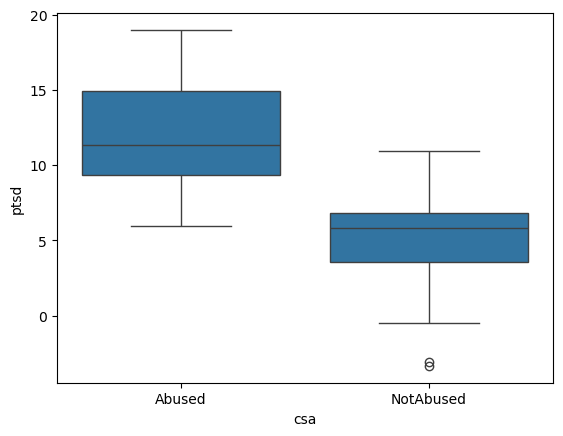

In [7]:
sns.boxplot(x="csa", y="ptsd", data=sexab);

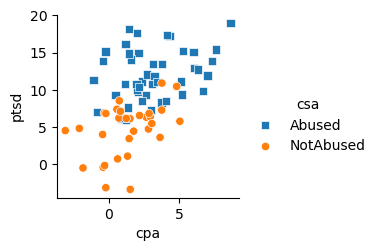

In [11]:
sns.pairplot(x_vars="cpa", y_vars="ptsd", data=sexab, hue="csa", markers=["s","o"]);

- Individuals in the abused group exhibit higher PTSD levels compared to those in the non-abused group.
- We test this difference and find that it is significant.
    - This test assumes equal variance between the two groups. This assumption is reasonable and ensures the results are comparable with the upcoming linear modeling.

In [12]:
stats.ttest_ind(sexab.ptsd[sexab.csa == 'Abused'], sexab.ptsd[sexab.csa == 'NotAbused'])

TtestResult(statistic=8.938657095668173, pvalue=2.1719334389283135e-13, df=74.0)

- Our strategy is to include qualitative predictors to $y = X \beta + \varepsilon$, allowing us to use familiar estimation, inferential, and diagnostic techniques without learning new formulas for each configuration.
- To include qualitative predictors in $ y = X\beta + \varepsilon $, we can code them using dummy variables.
- We create two dummy variables, $d_1$ and $d_2$.
$$ d_i =\left\{\begin{matrix}0&\text{is not level i}\\1&\text{is level i}\\\end{matrix}\right.$$ 

In [13]:
df1 = (sexab.csa == 'Abused').astype(int)
df2 = (sexab.csa == 'NotAbused').astype(int)
X = np.column_stack((df1,df2))
lmod = sm.OLS(sexab.ptsd,sm.add_constant(X)).fit()
lmod.sumary()

       coefs stderr tvalues pvalues
const  5.546  0.270   20.53  0.0000
x1     6.395  0.403   15.87  0.0000
x2    -0.850  0.450   -1.89  0.0630

n=76 p=2 Residual SD=3.473 R-squared=0.52


- We see a warning about singularities.
- Some model output is produced, but its meaning is unclear.
- The NotAbused level appears insignificant, which is misleading and should be ignored.
- This identifiability issue can be understood by examining the X model matrix. We show the first, two middle, and last rows:

In [14]:
sm.add_constant(X)[[0,44,45,75],:]

array([[1., 1., 0.],
       [1., 1., 0.],
       [1., 0., 1.],
       [1., 0., 1.]])

- Using both in regression causes an error because their sum equals the intercept, leading to singularities. This means $X$ is not of full rank, having a rank of two instead of three. Thus, not all parameters can be identified, which is expected since we're using three parameters to model only two groups.
- To fix this, we should remove one dummy variable or the intercept. Once choice would be to eliminate d1:

In [16]:
lmod = sm.OLS(sexab.ptsd,sm.add_constant(df2)).fit()
lmod.sumary()

       coefs stderr tvalues pvalues
const 11.941  0.518   23.07  0.0000
csa   -7.245  0.811   -8.94  0.0000

n=76 p=2 Residual SD=3.473 R-squared=0.52


- Compare this to the t-test output. The intercept of 11.941 is the mean for the "Abused" group. The parameter for $d_2$ represents the difference between the "Abused" and "NotAbused" groups. The mean for "NotAbused" groups is calculated as $11.941 - 7.245 = 4.696$. The t-value for $d_2$ is -8.94, which tests if this difference is zero and is identical (excepting 
the sign) to the test statistic from the t-test computed previously.
- An alternative approach is to eliminate the intercept term:

In [17]:
lmod = sm.OLS(sexab.ptsd,X).fit()
lmod.sumary()

    coefs stderr tvalues pvalues
x1 11.941  0.518   23.07  0.0000
x2  4.696  0.624    7.53  0.0000

n=76 p=2 Residual SD=3.473 R-squared=0.52


- This approach directly provides the means of the two groups from the dummy variable estimates. However, it doesn't give the t-test for the difference. The output tests whether the mean response in each group is zero, which is not interesting or believable.
- Dropping the intercept only works for a single factor (categorical variable) and doesn't generalize to multiple factors. Therefore, we prefer dropping one of the dummy variables instead.
- we don't need to manually create dummy variables; statsmodels with patsy can generate them directly by including the factor in the model formula:

In [18]:
lmod = smf.ols('ptsd ~ csa', sexab).fit()
lmod.sumary()

                  coefs stderr tvalues pvalues
Intercept        11.941  0.518   23.07  0.0000
csa[T.NotAbused] -7.245  0.811   -8.94  0.0000

n=76 p=2 Residual SD=3.473 R-squared=0.52


In [19]:
sexab.csa.dtype, sexab.ptsd.dtype

(dtype('O'), dtype('float64'))

- When a variable is non-numeric, dummy variables are created automatically, with one dropped to ensure identifiability, known as the reference level. Here, "Abused" is the reference level, encoded in the intercept of 11.941. The parameter estimate for "NotAbused" (-7.245) represents the difference from the reference level, making the mean response for "NotAbused" 11.941 - 7.245 = 4.696. Previously, we dropped the dummy variable $d_1$ to get the same result.
- Since “Abused” comes before “NotAbused” alphabetically, “Abused” is coded as 0 and “NotAbused” as 1.
- We can also create dummy variables in pandas:

In [20]:
sac = pd.concat([sexab, pd.get_dummies(sexab.csa)], axis=1)
sac.iloc[[0,44,45,75],:]

,cpa,ptsd,csa,Abused,NotAbused
1,2.04786,9.71365,Abused,True,False
45,5.11921,11.12798,Abused,True,False
46,1.49181,6.14200,NotAbused,False,True
76,0.81138,7.12918,NotAbused,False,True


In [21]:
lmod = smf.ols('ptsd ~ Abused', sac).fit()
lmod.sumary()

               coefs stderr tvalues pvalues
Intercept      4.696  0.624    7.53  0.0000
Abused[T.True] 7.245  0.811    8.94  0.0000

n=76 p=2 Residual SD=3.473 R-squared=0.52


- The reference level choice is arbitrary. Sometimes, a control or no-treatment level is the natural choice. Here, “NotAbused” is the natural reference level. By default, the first alphabetical level, “Abused,” is chosen. To change this, we use the relevel command:

In [23]:
lmod = smf.ols(
    'ptsd ~ C(csa, Treatment(reference="NotAbused"))',
    sexab).fit()
lmod.sumary()

                                                   coefs stderr tvalues pvalues
Intercept                                          4.696  0.624    7.53  0.0000
C(csa, Treatment(reference="NotAbused"))[T.Abused] 7.245  0.811    8.94  0.0000

n=76 p=2 Residual SD=3.473 R-squared=0.52


- Comparing the outputs shows that the fitted values, residuals, residual standard error, and $R^2$ are the same for either choice, but the parameterization differs.
- While we've only constructed a t-test using linear modeling, understanding how factor variables are handled is crucial for more advanced models.
- Our analysis shows that women who experienced childhood sexual abuse have higher PTSD levels. We also have data on varying levels of childhood physical abuse (CPA), which may affect PTSD. We need models to express how a factor like CSA and a quantitative variable like CPA relate to the response.
- Suppose we have a response y, a quantitative predictor x and a two-level factor variable d:
$$ d_i =\left\{\begin{matrix}0&\text{reference level}\\1&\text{treatment level i}\\\end{matrix}\right.$$ 
    - The same regression line for both levels: $y = β_0 + β_1 x + ε$. There is no effect for the factor.
    - Only with factor predictor: $y = β_0 + β_1 d + ε$.
    - Separate regressions line for each group with the same slope: $y = β_0 + β_1 x + β_2 d + ε$. $β_2$ is the vertical distance between the regression lines (i.e., the effect of the treatment).
    - Separate regressions line for each group with the different slopes:
$y = β_0 + β_1 x + β_2 d + β_3 xd + ε$, written as $y \sim x + d + d:x$ or $y \sim x*d$.
- To create the slope interaction term $d \cdot x$ in the X-matrix, multiply each element of $x$ by the corresponding element of $d$. This means that any interpretation of the factor's effect will also depend on the quantitative predictor.
- Estimation and testing remain the same. Interpretation is simpler without the interaction term.

In [24]:
lmod4 = smf.ols('ptsd ~ csa*cpa', sexab).fit()
lmod4.sumary()

                      coefs stderr tvalues pvalues
Intercept            10.557  0.806   13.09  0.0000
csa[T.NotAbused]     -6.861  1.075   -6.38  0.0000
cpa                   0.450  0.208    2.16  0.0342
csa[T.NotAbused]:cpa  0.314  0.368    0.85  0.3970

n=76 p=4 Residual SD=3.279 R-squared=0.58


- We can discover the coding by examining the X-matrix:

In [25]:
import patsy
patsy.dmatrix('~ csa*cpa', sexab)[[0, 44, 45, 75],]

array([[1.     , 0.     , 2.04786, 0.     ],
       [1.     , 0.     , 5.11921, 0.     ],
       [1.     , 1.     , 1.49181, 1.49181],
       [1.     , 1.     , 0.81138, 0.81138]])

- The interaction term cpa:csaAbused in the fourth column is the product of the second and third columns. It shows the slope change for the notAbused group. We display the fitted regression lines.

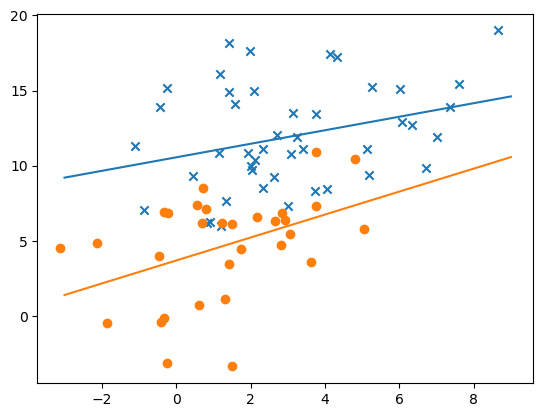

In [28]:
abused = (sexab.csa == "Abused")
plt.scatter(sexab.cpa[abused], sexab.ptsd[abused], marker='x')
xl,xu = [-3, 9]
a, b = (lmod4.params.iat[0], lmod4.params.iat[2])
plt.plot([xl,xu], [a+xl*b,a+xu*b])
plt.scatter(sexab.cpa[~abused], sexab.ptsd[~abused], marker='o')
a, b = (lmod4.params.iat[0]+lmod4.params.iat[1], 
        lmod4.params.iat[2]+lmod4.params.iat[3])
plt.plot([xl,xu], [a+xl*b,a+xu*b]);

- Since the interaction term is not significant, we can simplify the model by assuming the slopes are the same. This reduces the model to:

In [29]:
lmod3 = smf.ols('ptsd ~ csa+cpa', sexab).fit()
lmod3.sumary()

                  coefs stderr tvalues pvalues
Intercept        10.248  0.719   14.26  0.0000
csa[T.NotAbused] -6.273  0.822   -7.63  0.0000
cpa               0.551  0.172    3.21  0.0020

n=76 p=3 Residual SD=3.273 R-squared=0.58


- No further simplification is possible as the remaining predictors are significant.
- We plot the two parallel regression lines:

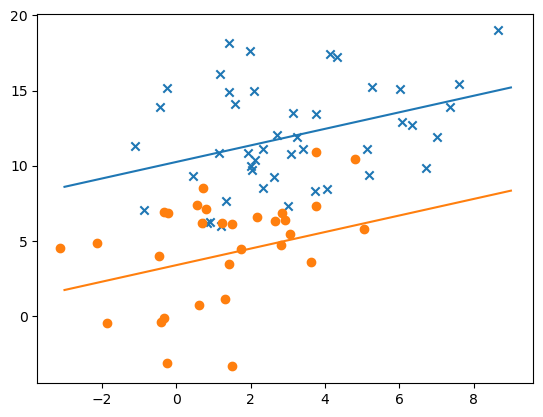

In [32]:
plt.scatter(sexab.cpa[abused], sexab.ptsd[abused], marker='x')
xl, xu = [-3, 9]
a, b = (lmod3.params.iat[0], lmod3.params.iat[2])
plt.plot([xl, xu], [a+xl*b, a+xu*b])
plt.scatter(sexab.cpa[~abused], sexab.ptsd[~abused], marker='o')
a, b = (lmod3.params.iat[0]+lmod4.params.iat[1], lmod3.params.iat[2])
plt.plot([xl, xu], [a+xl*b, a+xu*b]);

- Both lines have a slope of 0.551, but the “Abused” line is 6.273 higher than the “NonAbused.”
- The previous t-test showed an unadjusted effect of childhood sexual abuse at 7.245. After adjusting for childhood physical abuse, the effect on PTSD is slightly reduced.
- We can also compare confidence intervals for the effect of csa:

In [37]:
lmod3.conf_int().round(2)

,0,1
Intercept,8.82,11.68
csa[T.NotAbused],-7.91,-4.63
cpa,0.21,0.89


- Compared to the unadjusted difference of (5.6302, 8.8603), the confidence intervals in this case are similarly wide. However, in other scenarios, especially with designed experiments, adjusting for a covariate can improve the precision of effect estimates.
- The usual diagnostics should be performed. It’s important to check for any differences related to the categorical variable, as demonstrated here:

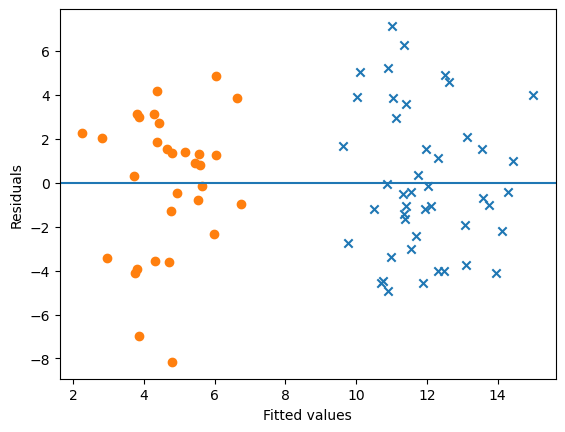

In [39]:
plt.scatter(lmod3.fittedvalues[abused], lmod3.resid[abused], marker='x')
plt.scatter(lmod3.fittedvalues[~abused], lmod3.resid[~abused], marker='o')
plt.xlabel("Fitted values"); plt.ylabel("Residuals"); plt.axhline(0);

- There are no clear problems. The two groups separate, showing similar variation. If they didn't, adjustments like using weights would be needed.
- The effect of csa can be adjusted for cpa, and vice versa. Now, consider a model with just cpa:

In [40]:
lmod1 = smf.ols('ptsd ~ cpa', sexab).fit()
lmod1.sumary()

          coefs stderr tvalues pvalues
Intercept 6.552  0.707    9.26  0.0000
cpa       1.033  0.212    4.87  0.0000

n=76 p=2 Residual SD=4.359 R-squared=0.24


- After adjusting for csa, the effect of cpa is reduced from 1.033 to 0.551.
- Finally, childhood physical abuse might not be the only factor affecting the impact of childhood sexual abuse. Other variables like socioeconomic status and age could also differ between the groups. Causal conclusions from observational studies should be approached with caution. For more details, see Rodriguez et al. (1997).